### Overview

#### This project is Identifying Personal Attacks in Wikipedia Comments, in this project build 3 ML model to anlaysis the relationship between non-tack and tack comments

### Packages Use

In [1]:
import pandas as pd
import numpy as np
import urllib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer


from sklearn import feature_extraction  
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support,classification_report,confusion_matrix,recall_score,f1_score,hamming_loss
from sklearn.svm import LinearSVC

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
import re
import time
import nltk


### Data Feature and Clean

In [2]:
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

# You can edit the code here to download only once, and not download it later                
#download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
#download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [3]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

In [4]:
comments.head(5)

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


In [5]:
comments.describe()

,year
count,115864.000000
mean,2009.224306
std,2.900431
min,2001.000000
25%,2007.000000
50%,2009.000000
75%,2011.000000
max,2016.000000


In [6]:
annotations.head(5)

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


In [7]:
annotations.describe()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
count,1.365217e+06,1.365217e+06,1.365217e+06,1.365217e+06,1.365217e+06,1.365217e+06,1.365217e+06
mean,2.999745e+08,1.339286e+03,7.524811e-03,1.117822e-01,3.264756e-02,3.231794e-02,1.669595e-01
std,1.984214e+08,1.053387e+03,8.641871e-02,3.150985e-01,1.777125e-01,1.768432e-01,3.729399e-01
min,3.767500e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.268677e+08,4.450000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.699976e+08,1.079000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.592911e+08,2.062000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.998972e+08,4.052000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


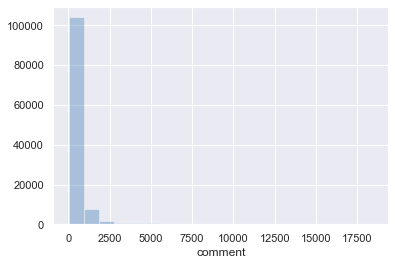

In [8]:
sns.set(color_codes=True)
comments_len = comments.comment.str.len()
sns.distplot(comments_len, kde=False, bins=20, color="steelblue")

In [9]:
annotations_labels = annotations[['quoting_attack', 'recipient_attack',
                      'third_party_attack', 'other_attack', 'attack']]
label_count = annotations_labels.sum()

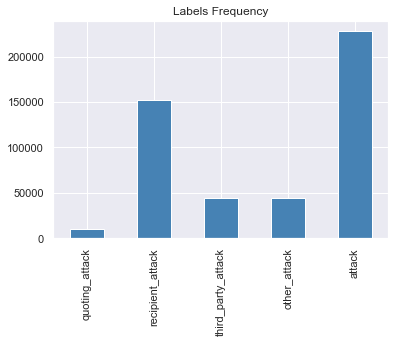

In [10]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

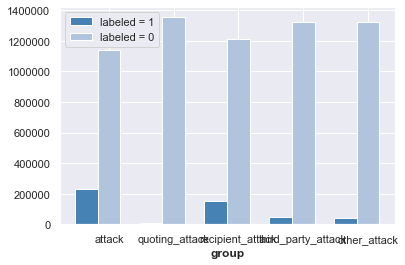

In [11]:
# Code to draw bar graph for visualising distribution of classes within each label.
barWidth = 0.35

bars1 = [sum(annotations['attack'] == 1), sum(annotations['quoting_attack'] == 1), sum(annotations['recipient_attack'] == 1),
         sum(annotations['third_party_attack'] == 1), sum(annotations['other_attack'] == 1)]
bars2 = [sum(annotations['attack'] == 0), sum(annotations['quoting_attack'] == 0), sum(annotations['recipient_attack'] == 0),
         sum(annotations['third_party_attack'] == 0), sum(annotations['other_attack'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['attack', 'quoting_attack', 'recipient_attack', 'third_party_attack', 'other_attack'])
plt.legend()
plt.show()

In [12]:
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [13]:
def processQues(chat):
    chat = chat.lower()
    chat = re.sub('@[^\s]+','',chat)
    chat = re.sub('[\s]+', ' ', chat)
    chat = re.sub('\[\d+\]+', ' ', chat)
    chat = re.sub(r'#([^\s]+)', r'\1', chat)
    chat = re.sub(r'[\!:\?\-\'\``\\/]', r'', chat)
    chat = chat.strip('\'"')
    chat = chat.replace(',','')
    chat = chat.replace('.','')
    chat = chat.replace('<','')
    chat = chat.replace('>','')
    chat = chat.replace('[','')
    chat = chat.replace(']','')
    chat = chat.replace(')','')
    chat = chat.replace(';','')
    return chat

In [14]:
stop_words = set(stopwords.words('english'))

In [15]:
def CleanText(comment):
    comment=processQues(comment)
    comment = nltk.word_tokenize(comment)
    w = [wd for wd in comment if wd not in stop_words]
    return " ".join(w)

In [16]:
comments["comment"]=comments["comment"].apply(CleanText)

In [17]:
#drop duplicated value of the comments data
comments.duplicated().sum()
comments.drop_duplicates(inplace=True)

In [18]:
comments.head(5)

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,creative dictionary definitions terms insuranc...,2002,False,article,random,train
44816,term standard model less npov think wed prefer...,2002,False,article,random,train
49851,true false situation march 2002 saudi proposal...,2002,False,article,random,train
89320,next maybe could work less condescending sugge...,2002,True,article,random,dev
93890,page need disambiguation,2002,True,article,random,train


# Feature Extraction Using tokenize and tfidvetorizer
### And add 'year' variable to compare the accuracy, the result is not add 'year' variable is better 

In [19]:
vectorizer = CountVectorizer(max_features = 500, ngram_range = (1,2))
vectorizer_comment = vectorizer.fit_transform(comments['comment'])
transformer=TfidfTransformer(norm = 'l2')
tfidf=transformer.fit_transform(vectorizer_comment)
X=tfidf.toarray()

In [20]:
Y = []

x1 = []
x1_year = []
index = 0
years = comments["year"].tolist()
for i in range(len(annotations['attack'])):
    if annotations['attack'][i]==1:
        temp = X[i]
        temp = temp.tolist()
        x1.append(temp)
        x1_year.append(years[i])
        index += 1
        if index>1000:
            break

x2 = []
x2_year = []
index = 0
for i in range(len(annotations['attack'])):
    if annotations['attack'][i]==0:
        temp = X[i]
        temp = temp.tolist()
        x2.append(temp)
        x2_year.append(years[i])
        index += 1
        if index>1000:
            break
x = []
x_year = []
for i in range(len(x1)):
    x.append(x1[i])
    temp = x1[i].copy()
    temp.append(x1_year[i])
    x_year.append(temp)
    Y.append(1)
    
    x.append(x2[i])
    temp = x2[i].copy()
    temp.append(x2_year[i])
    x_year.append(temp)
    Y.append(0)
    
x,x_year,Y = np.array(x),np.array(x_year),np.array(Y)
x.shape,x_year.shape,Y.shape

((2002, 500), (2002, 501), (2002,))

In [41]:
#compare the effect of adding the year variable and not adding the year variable
#without year variable, better accuracy
clf_origal = SVC()
clf_origal.fit(x,Y)
score_origal = clf_origal.score(x,Y)

clf_year = SVC()
clf_year.fit(x_year,Y)
score_year = clf_year.score(x_year,Y)
score_year,score_origal

/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(0.906093906093906, 0.6543456543456544)

# Evaluation Index
#### The main indicator to measure the model is F1-score.
### Cross-validation K-folder
#### Use cross-validation to compare model RandomForestClassifier and SVC

In [22]:
clf1 = RandomForestClassifier()
clf2 = SVC()
clf3 = KNeighborsClassifier()

In [23]:
def  cross_validation_score ( classifier ,  X_train ,  y_train ):
    model =[]
    name = classifier.__class__.__name__.split('.')[-1]
    classifier.fit(X_train,y_train)
    recall = cross_val_score(
            classifier, X_train, y_train, cv=10, scoring='recall')
    f1 = cross_val_score(classifier, X_train, y_train, cv=10, scoring='f1')
    accuracy = cross_val_score(classifier, X_train, y_train, cv=10, scoring='accuracy')
    precision = cross_val_score(classifier, X_train, y_train, cv=10, scoring='precision')
    support = cross_val_score(classifier, X_train, y_train, cv=10, scoring='neg_log_loss')
    for label in [0,1]:
        
        model.append([name, label, recall[label], f1[label],accuracy[label],precision[label],support[label]])

    return model

In [24]:
clf2 = SVC(probability=True)
model1 = pd.DataFrame(cross_validation_score(clf1, x, Y))
model2 = pd.DataFrame(cross_validation_score(clf2, x, Y))
model3 = pd.DataFrame(cross_validation_score(clf3, x, Y))

/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will chan

In [25]:
model = pd.concat([model1, model2,model3])
model.columns = ['Model', 'Label', 'Recall', 'F1','accuracy', 'precision', 'support']
modelShow = model.reset_index()
modelShow[['Model', 'Label', 'Recall', 'F1','accuracy', 'precision', 'support']]

,Model,Label,Recall,F1,accuracy,precision,support
0,RandomForestClassifier,0,0.396040,0.363636,0.514851,0.514286,-1.130100
1,RandomForestClassifier,1,0.500000,0.463277,0.545000,0.493333,-0.934696
2,SVC,0,0.247525,0.333333,0.504950,0.510204,-0.693147
3,SVC,1,0.590000,0.536364,0.490000,0.491667,-0.693147
4,KNeighborsClassifier,0,0.584158,0.541284,0.504950,0.504274,-2.274133
5,KNeighborsClassifier,1,0.700000,0.583333,0.500000,0.500000,-1.961771


## Modle evaluate

In [26]:
def score(classifier, X_train, y_train, X_test, y_test):
    methods = []
    hloss = []
    name = classifier.__class__.__name__.split('.')[-1]
#     predict_df = pd.DataFrame()
#     predict_df['rev_id'] = test_y['rev_id']  
    classifier.fit(X_train, y_train)
    predicted = classifier.predict(X_test)

#         predict_df[label] = predicted

    recall = cross_val_score(
            classifier, X_train, y_train, cv=2, scoring='recall')
    f1 = cross_val_score(classifier, X_train, y_train, cv=2, scoring='f1')

    conf_mat = confusion_matrix(y_test, predicted)
    
    accuracy = cross_val_score(classifier, X_train, y_train, cv=2, scoring='accuracy')
    precision = cross_val_score(classifier, X_train, y_train, cv=2, scoring='precision')
    support = cross_val_score(classifier, X_train, y_train, cv=2, scoring='neg_log_loss')
    for label in [0,1]:
        
        

        methods.append([name, label, recall[label], f1[label], conf_mat[label],accuracy[label],precision[label],support[label]])
        
    return methods

In [27]:
evaluate1 = score(clf1, x,Y, x,Y)
evaluate2 = score(clf2, x,Y, x,Y)
evaluate3 = score(clf3, x,Y, x,Y)

/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/diyang/anaconda3/lib/python3.7/site-packages/

In [28]:
# Creating a dataframe to show summary of results.
evaluate1 = pd.DataFrame(evaluate1)
evaluate2 = pd.DataFrame(evaluate2)
evaluate3 = pd.DataFrame(evaluate3)
methods = pd.concat([evaluate1, evaluate2, evaluate3])

methods.columns = ['Model', 'Label', 'Recall', 'F1','conf_mat','accuracy', 'precision', 'support']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1','conf_mat','accuracy', 'precision', 'support']]

,Model,Label,Recall,F1,conf_mat,accuracy,precision,support
0,RandomForestClassifier,0,0.425150,0.486081,"[968, 33]",0.511976,0.529976,-0.905510
1,RandomForestClassifier,1,0.528000,0.548944,"[35, 966]",0.536000,0.535032,-0.908519
2,SVC,0,0.632735,0.578467,"[527, 474]",0.538922,0.532773,-0.693287
3,SVC,1,0.956000,0.662968,"[218, 783]",0.514000,0.507431,-0.693595
4,KNeighborsClassifier,0,0.495010,0.500505,"[689, 312]",0.505988,0.506122,-1.569686
5,KNeighborsClassifier,1,0.568000,0.524469,"[281, 720]",0.485000,0.487136,-1.901590


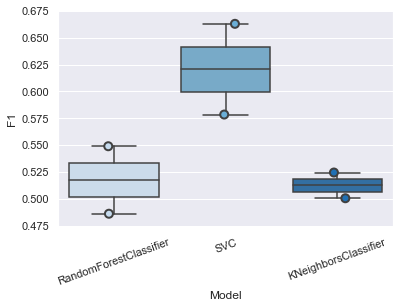

In [29]:
##F1 Score
ax = sns.boxplot(x='Model', y='F1', data=methods, palette="Blues")
sns.stripplot(x='Model', y='F1', data=methods,
              size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Blues")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.show()

## Modle Visualization

Plot for Multinomial Random Forest


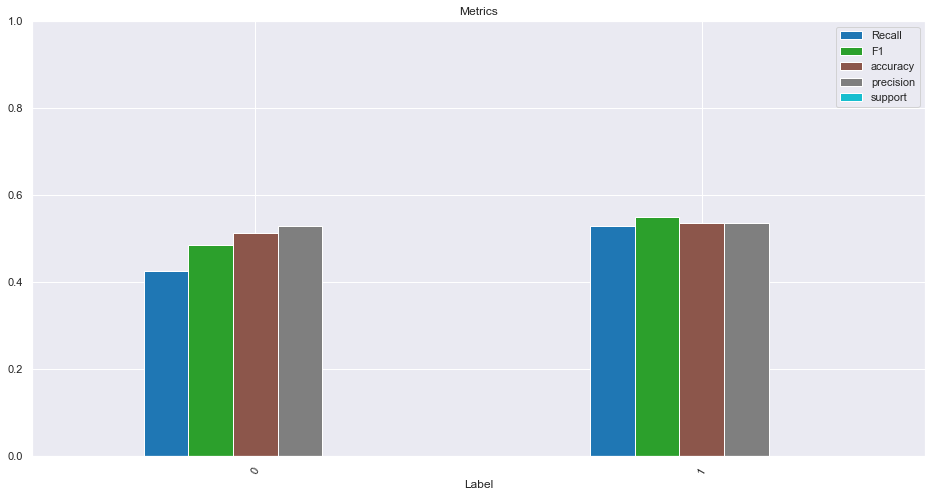

In [30]:
print("Plot for Multinomial Random Forest")
m2 = methods[methods.Model == 'RandomForestClassifier']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for svc


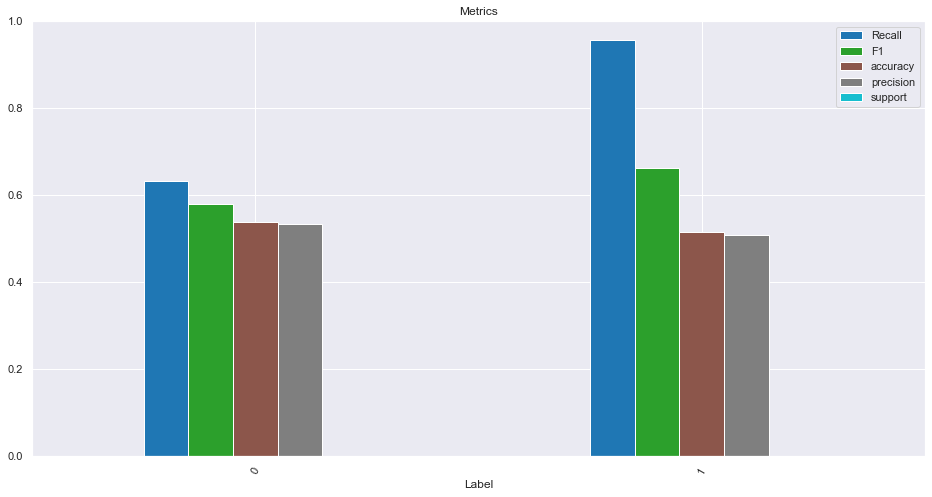

In [31]:
print("Plot for svc")
m2 = methods[methods.Model == 'SVC']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for KNN


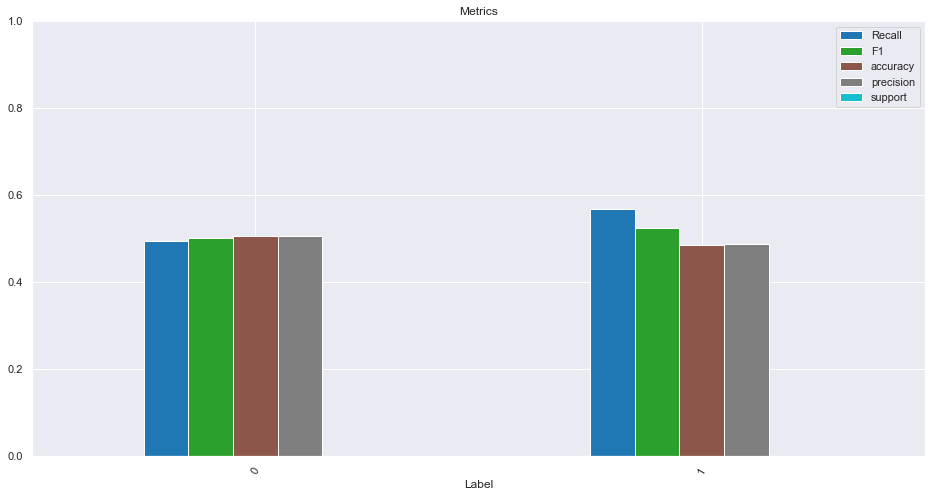

In [32]:
print("Plot for KNN")
m2 = methods[methods.Model == 'KNeighborsClassifier']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

## Confusion Metrix of Model

In [33]:
def drawConfusionMatrix(cm):
    cm = cm.reshape((2,1))
    print(cm.shape)
    cm = cm.astype('float')
    ax = plt.axes()
    sns.heatmap(cm,
                annot=True,
                annot_kws={"size": 16},
                cmap="Blues",
                fmt='.2f',
                linewidths=2,
                linecolor='steelblue',
                xticklabels=("Non-attack", "attack"),
                yticklabels=("Non-attack", "attack"))

    plt.ylabel('True', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.show()

In [34]:
def Matrix(label):
 
    print(f"{label} labelling")
    meth_label = meth[meth.Label==label]
    for i in range(0, len(meth_label)):
        print()
        print(f"****  {meth['Model'][i]}  ***")
        cm = meth['conf_mat'][i]
        drawConfusionMatrix(cm)

1 labelling

****  RandomForestClassifier  ***
(2, 1)


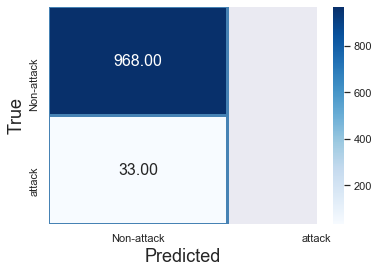


****  RandomForestClassifier  ***
(2, 1)


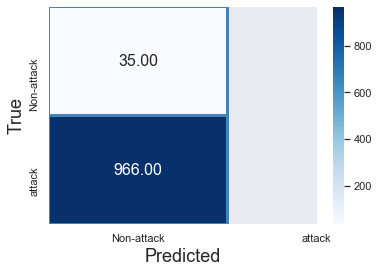


****  SVC  ***
(2, 1)


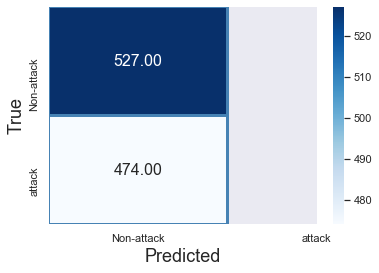

0 labelling

****  RandomForestClassifier  ***
(2, 1)


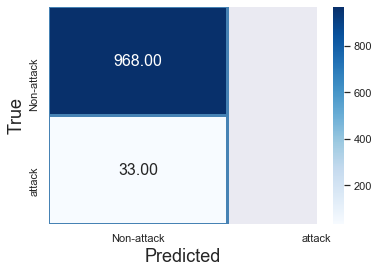


****  RandomForestClassifier  ***
(2, 1)


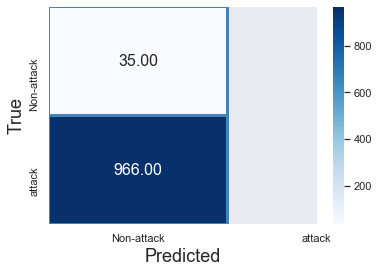


****  SVC  ***
(2, 1)


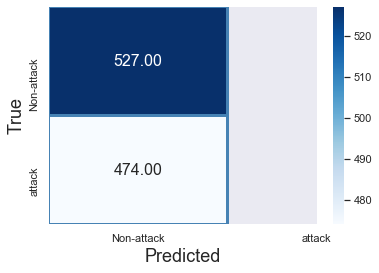

In [35]:
Matrix(1)
Matrix(0)

# step5. Hyperparameter Tuning

In [36]:
pipe_lr = Pipeline([
    ('RandomForest', RandomForestClassifier(class_weight="balanced"))
])

pipe_linear_svm = Pipeline([
    ('SVC', SVC(class_weight={1: 20}))
])

pipelines = [pipe_lr, pipe_linear_svm]

In [37]:
score_df = []
for pipe in pipelines:
    f1_values = []
    recall_values = []
    hl = []
    training_time = []
    pipe.fit(x, Y)
    recall = cross_val_score(
            pipe, x, Y, cv=2, scoring='recall')
    f1 = cross_val_score(pipe, x, Y, cv=2, scoring='f1')
    for label in [0,1]:
        start = time.time()

#         f1_values.append(f1_score(
#             y_test[y_test==label], predicted, average="weighted"))
#         recall_values.append(recall_score(
#             y_test[y_test==label], predicted, average="weighted"))
        f1_values.append(f1[label])
        recall_values.append(recall[label])
        training_time.append(time.time()-start)
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]

#     hamming_loss_score = hamming_loss(
#         y_test[y_test==label], predicted)

    val = [name, np.mean(f1_values), np.mean(recall_values), np.mean(training_time)]
    score_df.append(val)

/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will chan

In [38]:
scores = pd.DataFrame(score_df,)
scores.columns = ['Model','F1','Recall', 'training_time']
scores

,Model,F1,Recall,training_time
0,RandomForestClassifier,0.507813,0.503553,0.000001
1,SVC,0.666667,1.000000,0.000002


## step5. Hyperparameter Tuningand RandomizedSearchCV 

In [39]:
X_train,y_train = X[:5000],annotations['attack'][:5000]
x_test,y_test = X[5000:6000],annotations['attack'][5000:6000]
model6 = SVC()#SVC
param_grid = {'C':[0.0001,0.00001,0.001],'gamma':[0.01,0.0001]}
grid_search = GridSearchCV(model6,param_grid,n_jobs=1,verbose=2)
grid_search.fit(X_train,y_train)
best_par = grid_search.best_estimator_.get_params()
print('best parameter= ',str(best_par))
clf = SVC(kernel='rbf',C=best_par['C'],gamma=best_par['gamma'],probability=True)
clf.fit(X_train,y_train)
# y_true = y_train[test_index]

    
y_pred = clf.predict(x_test)
met = classification_report(y_test,y_pred)
print(met)
score6 = clf.score(x_test,y_test)
score6

/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=0.0001, gamma=0.01 ............................................
[CV] ............................. C=0.0001, gamma=0.01, total=   0.9s
[CV] C=0.0001, gamma=0.01 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ............................. C=0.0001, gamma=0.01, total=   0.9s
[CV] C=0.0001, gamma=0.01 ............................................
[CV] ............................. C=0.0001, gamma=0.01, total=   0.9s
[CV] C=0.0001, gamma=0.0001 ..........................................
[CV] ........................... C=0.0001, gamma=0.0001, total=   0.9s
[CV] C=0.0001, gamma=0.0001 ..........................................
[CV] ........................... C=0.0001, gamma=0.0001, total=   0.9s
[CV] C=0.0001, gamma=0.0001 ..........................................
[CV] ........................... C=0.0001, gamma=0.0001, total=   0.9s
[CV] C=1e-05, gamma=0.01 .............................................
[CV] .............................. C=1e-05, gamma=0.01, total=   0.9s
[CV] C=1e-05, gamma=0.01 .............................................
[CV] .............................. C=1e-05, gamma=0.01, total=   0.9s
[CV] C=1e-05, gamma=0.01 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   16.6s finished


best parameter=  {'C': 0.0001, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       957
         1.0       0.00      0.00      0.00        43

    accuracy                           0.96      1000
   macro avg       0.48      0.50      0.49      1000
weighted avg       0.92      0.96      0.94      1000



0.957

## add threshold 

In [40]:
X_train,y_train = X[:5000],annotations['attack'][:5000]
x_test,y_test = X[5000:6000],annotations['attack'][5000:6000]
model7 = SVC()#SVC
model7 = SVC(kernel='rbf',C=0.001,gamma=0.01,probability=True)
model7.fit(X_train,y_train)
##### add threshold
y_score = model7.decision_function(x_test)
# y_score
y_score = np.where(y_score > -0.5, 1, 0)
#####
met = classification_report(y_test,y_score)
print(met)

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       957
         1.0       0.00      0.00      0.00        43

    accuracy                           0.96      1000
   macro avg       0.48      0.50      0.49      1000
weighted avg       0.92      0.96      0.94      1000



/Users/diyang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### a. What did you learn from visualizing the data as suggested in Section 2 above?
#### learned how to collected the random sample
### b. What text cleaning methods did you try? Which are the ones you included in the final code?
#### Try to find null, like isnull(), and drop duplicate, df.duplicate()
#### I used ```dulicate()``` and ```replace()``` ``` word_tokenize```,  ```lower()```  and ```strip()``` method
### c. What are the features you considered using? Which features did you use in the final code?
#### consider using TFIDF and tokenize() function. Using TFID compare the 'year' variable.
### d. How did you decide to use the ‘attack’ information from different annotators? Did you average them, or use a number threshold, or did you use some other method to use this information?
#### The classification threshold is 0.5. If the value is higher than the threshold, it means "1"; if the value is lower than the threshold, it means "0".
### e. Did you add any special optimizations to your code? If so, describe them briefly.
#### not use
### f. What are the ML methods you tried out, and what were your best results with each method? Which was the best ML method you saw before tuning hyperparameters?
#### RandomForest, KNN and SVC, the SVC is the best
### g. What hyperparameter tuning did you do, and by how many percentage points did your accuracy
#### Using GridSearchCV, 0.13 Percentage point increased
### go up because of hyper-parameter tuning?
#### I think it is.